<a href="https://www.kaggle.com/code/lynnclemons/superstore-data-cleaning-transformation?scriptVersionId=291506978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/sample-supermarket-dataset/SampleSuperstore.csv



<div style="background-color:#2F3E34; padding:15px; border-radius:8px; margin-top:20px;">
  <h2 style="color:#F4F0EB; margin:0;">1. Introduction</h2>
</div>


---


This notebook uses SQL (DuckDB) and Python to explore the Sample Superstore dataset and answer real business questions about sales, profit, product performance, shipping efficiency, and regional trends.

The goals of this project are to:

- Practice writing clean, readable SQL queries  
- Analyze business performance using real-world retail data  
- Demonstrate core skills expected of a junior data or BI analyst  
- Build a foundation for future dashboards or BI reports  

Because this version of the dataset does **not** include customer or date fields,  
the analysis focuses on **category-level**, **regional**, **shipping**, and **discount** performance rather than customer segmentation or time-series analysis.

---


In [2]:
import duckdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)



## 1.1 Tools and Approach

This project is designed to demonstrate my ability to work with both SQL and Python, while also showing how I integrate modern tools into my learning process. I use SQL for structured querying and data exploration, and Python for deeper analysis and visualization. This is done with the intent to display work in the context of real-world data analysis.

I come from a strong foundation in Excel, which is where most of my early data work began. I also have working knowledge of programs like Atlasti. SQL and Python are newer tools for me, and I do not feel as naturally confident with them yet. To bridge that gap, I am still building my technical foundation, and I actively use AI-assisted development to accelerate learning and improve accuracy. Tools like ChatGPT help me debug errors, clarify syntax,validate logic, and reinforce concepts as I grow. This mirrors how a junior analyst would seek guidance from senior team members while building real-world experience. This blended approach also reflects how modern data professionals work: combining SQL, Python, and AI-assisted problem solving to produce clean, reliable, and insightful analysis.

All insights, interpretations, and analytical decisions in this notebook are my own, and I am highly motivated to continue expanding my skillset.
My goal is to become fully fluent across SQL, Python, and BI tools so I can contribute meaningful, well-structured analysis in any professional environment.

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">


<div style="background-color:#2F3E34; padding:15px; border-radius:8px; margin-top:20px;">
  <h2 style="color:#F4F0EB; margin:0;">2. Environment Setup</h2>
</div>


I load the dataset into DuckDB for SQL querying and convert it into a Pandas DataFrame for visualization.

---


In [3]:
file_path = "/kaggle/input/sample-supermarket-dataset/SampleSuperstore.csv"

duckdb.sql(f"""
    CREATE OR REPLACE TABLE superstore AS
    SELECT * FROM read_csv_auto('{file_path}')
""")

duckdb.sql("SELECT * FROM superstore LIMIT 5")


┌────────────────┬───────────┬───────────────┬─────────────────┬────────────┬─────────────┬─────────┬─────────────────┬──────────────┬──────────┬──────────┬──────────┬──────────┐
│   Ship Mode    │  Segment  │    Country    │      City       │   State    │ Postal Code │ Region  │    Category     │ Sub-Category │  Sales   │ Quantity │ Discount │  Profit  │
│    varchar     │  varchar  │    varchar    │     varchar     │  varchar   │    int64    │ varchar │     varchar     │   varchar    │  double  │  int64   │  double  │  double  │
├────────────────┼───────────┼───────────────┼─────────────────┼────────────┼─────────────┼─────────┼─────────────────┼──────────────┼──────────┼──────────┼──────────┼──────────┤
│ Second Class   │ Consumer  │ United States │ Henderson       │ Kentucky   │       42420 │ South   │ Furniture       │ Bookcases    │   261.96 │        2 │      0.0 │  41.9136 │
│ Second Class   │ Consumer  │ United States │ Henderson       │ Kentucky   │       42420 │ South   │ Fur

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">


<div style="background-color:#2F3E34; padding:15px; border-radius:8px;">
  <h2 style="color:#F4F0EB; margin:0;">3. Data Preview & Structure</h2>
</div>


Before analysis, I review the table structure and confirm the available columns.
This version of the dataset includes product, geography, shipping, and pricing fields,
but does not include customer identifiers or dates.

---


In [4]:
# View column names and a few sample rows
duckdb.sql("PRAGMA table_info('superstore')")


┌───────┬──────────────┬─────────┬─────────┬────────────┬─────────┐
│  cid  │     name     │  type   │ notnull │ dflt_value │   pk    │
│ int32 │   varchar    │ varchar │ boolean │  varchar   │ boolean │
├───────┼──────────────┼─────────┼─────────┼────────────┼─────────┤
│     0 │ Ship Mode    │ VARCHAR │ false   │ NULL       │ false   │
│     1 │ Segment      │ VARCHAR │ false   │ NULL       │ false   │
│     2 │ Country      │ VARCHAR │ false   │ NULL       │ false   │
│     3 │ City         │ VARCHAR │ false   │ NULL       │ false   │
│     4 │ State        │ VARCHAR │ false   │ NULL       │ false   │
│     5 │ Postal Code  │ BIGINT  │ false   │ NULL       │ false   │
│     6 │ Region       │ VARCHAR │ false   │ NULL       │ false   │
│     7 │ Category     │ VARCHAR │ false   │ NULL       │ false   │
│     8 │ Sub-Category │ VARCHAR │ false   │ NULL       │ false   │
│     9 │ Sales        │ DOUBLE  │ false   │ NULL       │ false   │
│    10 │ Quantity     │ BIGINT  │ false   │ NUL

In [5]:
duckdb.sql("SELECT COUNT(*) AS total_rows FROM superstore")


┌────────────┐
│ total_rows │
│   int64    │
├────────────┤
│       9994 │
└────────────┘

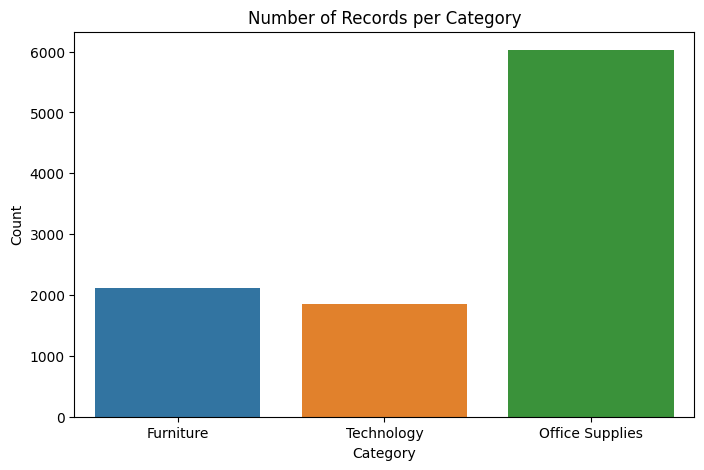

In [6]:
cat_counts = duckdb.sql("""
    SELECT "Category", COUNT(*) AS count
    FROM superstore
    GROUP BY "Category"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=cat_counts, x="Category", y="count")
plt.title("Number of Records per Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()


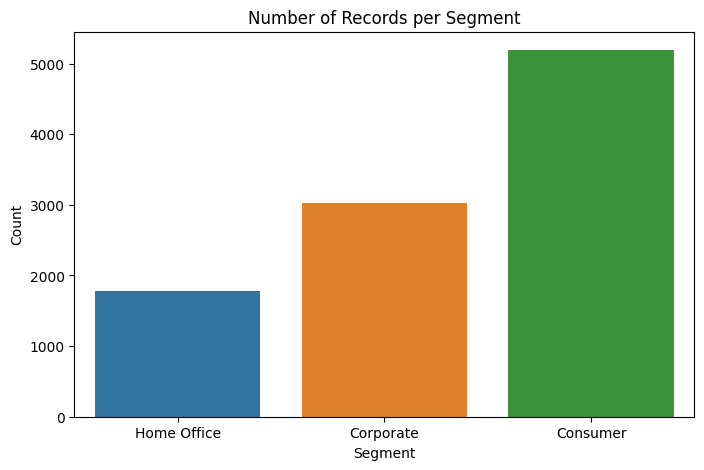

In [7]:
seg_counts = duckdb.sql("""
    SELECT "Segment", COUNT(*) AS count
    FROM superstore
    GROUP BY "Segment"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=seg_counts, x="Segment", y="count")
plt.title("Number of Records per Segment")
plt.xlabel("Segment")
plt.ylabel("Count")
plt.show()


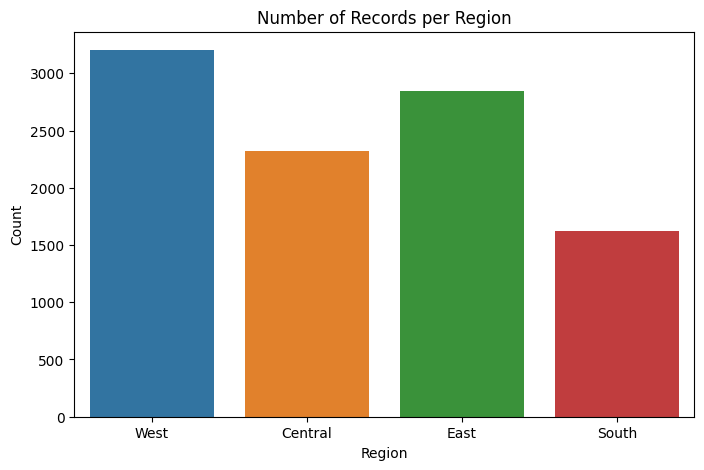

In [8]:
region_counts = duckdb.sql("""
    SELECT "Region", COUNT(*) AS count
    FROM superstore
    GROUP BY "Region"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=region_counts, x="Region", y="count")
plt.title("Number of Records per Region")
plt.xlabel("Region")
plt.ylabel("Count")
plt.show()


## 3.1 Data Quality Check – Duplicate Rows

Real-world datasets often contain duplicate entries caused by system errors, merging issues, or inconsistent data entry.
Duplicate rows can distort aggregate metrics like total sales, total profit, and average values, so detecting and removing them is a critical part of data cleaning.

This section identifies duplicate rows in the Superstore dataset, reviews them, and removes them before analysis.

---

## Step 1: Check for Duplicate Rows

The query below counts how many rows in the dataset appear more than once.

If the result is 0, the dataset has no exact duplicate rows.
If the result is greater than zero, duplicates should be reviewed and removed.

---

In [9]:
duckdb.sql("""
    SELECT 
        COUNT(*) - COUNT(DISTINCT COLUMNS(*)) AS duplicate_count
    FROM superstore
""")


┌─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │ duplicate_count │
│      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │      int64      │
├─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┼─────────────────┤
│            9990 │            9991 │            9993 │ 

## Step 2: Display Duplicate Rows (If Any)

This query below returns all rows that appear more than once in the dataset using a window function:

This helps confirm whether duplicates are caused by data entry errors or represent true repeated transactions.

---

In [10]:
duckdb.sql("""
    SELECT *
    FROM superstore
    QUALIFY ROW_NUMBER() OVER (
        PARTITION BY 
            "Ship Mode", "Segment", "Country", "City", "State",
            "Postal Code", "Region", "Category", "Sub-Category",
            "Sales", "Quantity", "Discount", "Profit"
    ) > 1
""")


┌────────────────┬─────────────┬───────────────┬───────────────┬──────────────┬─────────────┬─────────┬─────────────────┬──────────────┬─────────┬──────────┬──────────┬──────────┐
│   Ship Mode    │   Segment   │    Country    │     City      │    State     │ Postal Code │ Region  │    Category     │ Sub-Category │  Sales  │ Quantity │ Discount │  Profit  │
│    varchar     │   varchar   │    varchar    │    varchar    │   varchar    │    int64    │ varchar │     varchar     │   varchar    │ double  │  int64   │  double  │  double  │
├────────────────┼─────────────┼───────────────┼───────────────┼──────────────┼─────────────┼─────────┼─────────────────┼──────────────┼─────────┼──────────┼──────────┼──────────┤
│ Standard Class │ Home Office │ United States │ Seattle       │ Washington   │       98105 │ West    │ Furniture       │ Furnishings  │   22.14 │        3 │      0.0 │   6.4206 │
│ Same Day       │ Home Office │ United States │ San Francisco │ California   │       94122 │ West  

## Step 3: Remove Duplicate Rows

If duplicates exist, the command below replaces the current table with a clean version that removes all exact duplicates:

This ensures downstream analysis is run on accurate, clean data.

---

In [11]:
duckdb.sql("""
    CREATE OR REPLACE TABLE superstore AS
    SELECT DISTINCT *
    FROM superstore
""")


## Step 4: Verify Row Count After Cleaning

A quick check confirms whether duplicate removal reduced the dataset size. Using the code below can do this. 

If the row count has decreased, duplicates were present and successfully removed.
If the number remains unchanged, no duplicates existed.

---

In [12]:
duckdb.sql("SELECT COUNT(*) AS total_rows_after_cleaning FROM superstore")


┌───────────────────────────┐
│ total_rows_after_cleaning │
│           int64           │
├───────────────────────────┤
│                      9977 │
└───────────────────────────┘

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">4. Basic Exploration</h2>
</div>



We begin with a quick overview of the main categorical fields:
Category, Segment, and Region.

---


In [13]:
duckdb.sql("""
    SELECT DISTINCT "Category" 
    FROM superstore
    ORDER BY "Category"
""")


┌─────────────────┐
│    Category     │
│     varchar     │
├─────────────────┤
│ Furniture       │
│ Office Supplies │
│ Technology      │
└─────────────────┘

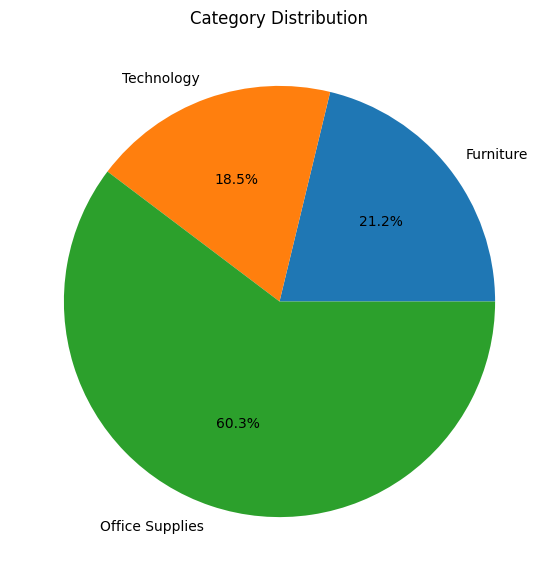

In [14]:
plt.figure(figsize=(7,7))
plt.pie(cat_counts["count"], labels=cat_counts["Category"], autopct="%1.1f%%")
plt.title("Category Distribution")
plt.show()


In [15]:
duckdb.sql("""
    SELECT DISTINCT "Segment" 
    FROM superstore
    ORDER BY "Segment"
""")


┌─────────────┐
│   Segment   │
│   varchar   │
├─────────────┤
│ Consumer    │
│ Corporate   │
│ Home Office │
└─────────────┘

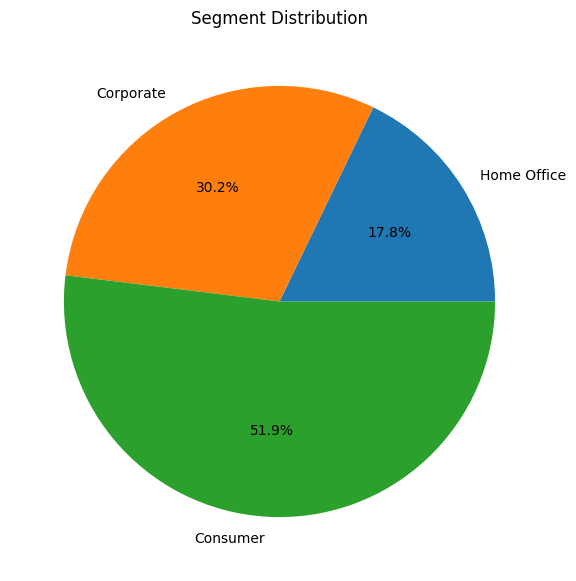

In [16]:
plt.figure(figsize=(7,7))
plt.pie(seg_counts["count"], labels=seg_counts["Segment"], autopct="%1.1f%%")
plt.title("Segment Distribution")
plt.show()


In [17]:
duckdb.sql("""
    SELECT DISTINCT "Region" 
    FROM superstore
    ORDER BY "Region"
""")
region_counts = duckdb.sql("""
    SELECT "Region", COUNT(*) AS count
    FROM superstore
    GROUP BY "Region"
    ORDER BY "Region"
""").df()
region_counts


,Region,count
0,Central,2319
1,East,2845
2,South,1620
3,West,3193


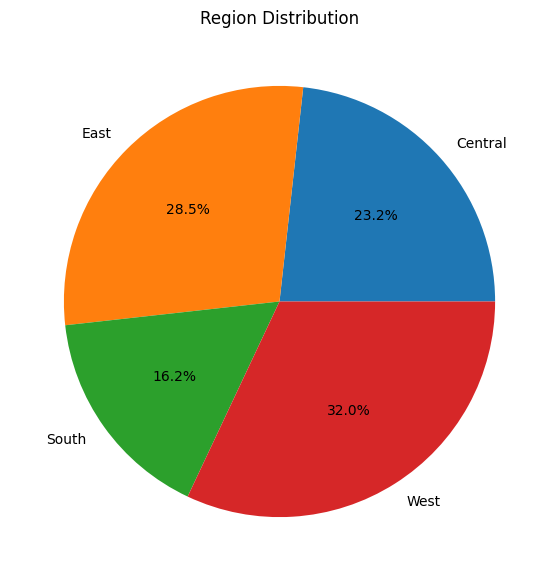

In [18]:
plt.figure(figsize=(7,7))
plt.pie(region_counts["count"], labels=region_counts["Region"], autopct="%1.1f%%")
plt.title("Region Distribution")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">5. Overall Sales & Profit Overview</h2>
</div>



A high-level snapshot of business performance:
- Total revenue  
- Total profit  
- Average sales per record  

This establishes the baseline for deeper analysis.

---



In [19]:
duckdb.sql("""
    SELECT 
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit,
        ROUND(AVG("Sales"), 2) AS avg_order_value
    FROM superstore
""")


┌─────────────┬──────────────┬─────────────────┐
│ total_sales │ total_profit │ avg_order_value │
│   double    │    double    │     double      │
├─────────────┼──────────────┼─────────────────┤
│  2296195.59 │    286241.42 │          230.15 │
└─────────────┴──────────────┴─────────────────┘

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#B19CD9; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">6. Sales & Profit by Category & Sub-Category</h2>
</div>


Here we explore which product groups drive sales and profitability.
This helps identify key revenue drivers and potential weak spots.

### 6.1 Sales and Profit by Category  
(Results below)

### 6.2 Top Sub-Categories  
(Results below)

---


In [20]:
# Sales and profit by Category
duckdb.sql("""
    SELECT 
        "Category",
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit
    FROM superstore
    GROUP BY "Category"
    ORDER BY total_sales DESC
""")


┌─────────────────┬─────────────┬──────────────┐
│    Category     │ total_sales │ total_profit │
│     varchar     │   double    │    double    │
├─────────────────┼─────────────┼──────────────┤
│ Technology      │   836154.03 │    145454.95 │
│ Furniture       │   741306.31 │     18421.81 │
│ Office Supplies │   718735.24 │    122364.66 │
└─────────────────┴─────────────┴──────────────┘

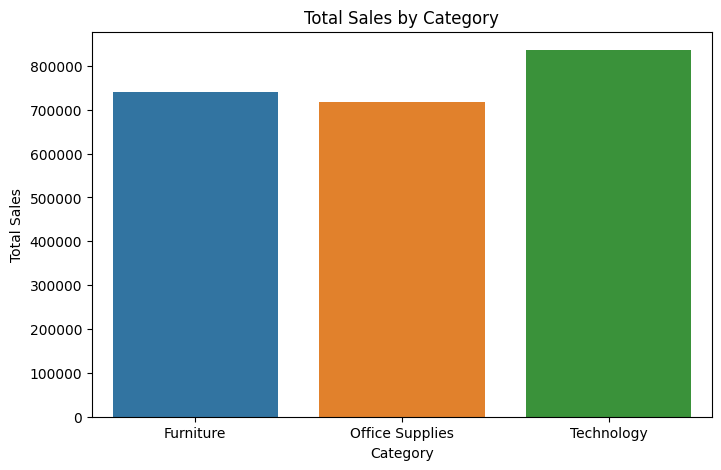

In [21]:
cat_sales = duckdb.sql("""
    SELECT "Category", SUM("Sales") AS total_sales
    FROM superstore
    GROUP BY "Category"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=cat_sales, x="Category", y="total_sales")
plt.title("Total Sales by Category")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.show()


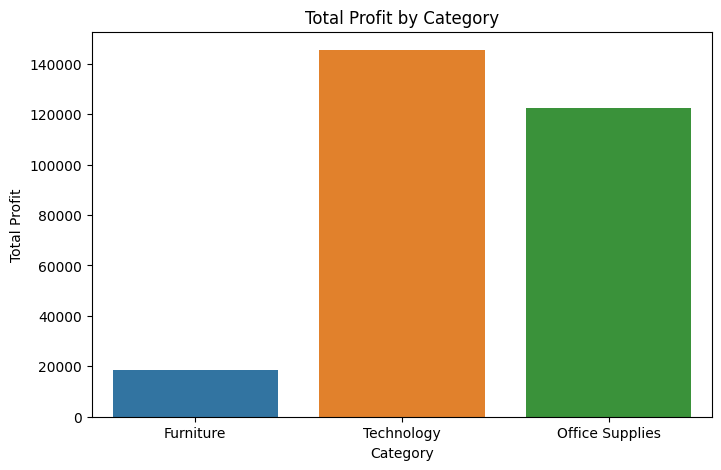

In [22]:
cat_profit = duckdb.sql("""
    SELECT "Category", SUM("Profit") AS total_profit
    FROM superstore
    GROUP BY "Category"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=cat_profit, x="Category", y="total_profit")
plt.title("Total Profit by Category")
plt.xlabel("Category")
plt.ylabel("Total Profit")
plt.show()


In [23]:
# Top 10 Sub-Categories by Sales
duckdb.sql("""
    SELECT 
        "Sub-Category",
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit
    FROM superstore
    GROUP BY "Sub-Category"
    ORDER BY total_sales DESC
    LIMIT 10
""")



┌──────────────┬─────────────┬──────────────┐
│ Sub-Category │ total_sales │ total_profit │
│   varchar    │   double    │    double    │
├──────────────┼─────────────┼──────────────┤
│ Phones       │   330007.05 │     44515.73 │
│ Chairs       │   327777.76 │     26567.13 │
│ Storage      │   223843.61 │     21278.83 │
│ Tables       │   206965.53 │    -17725.48 │
│ Binders      │   203409.17 │      30228.0 │
│ Machines     │   189238.63 │      3384.76 │
│ Accessories  │   167380.32 │     41936.64 │
│ Copiers      │   149528.03 │     55617.82 │
│ Bookcases    │    114880.0 │     -3472.56 │
│ Appliances   │   107532.16 │     18138.01 │
├──────────────┴─────────────┴──────────────┤
│ 10 rows                         3 columns │
└───────────────────────────────────────────┘

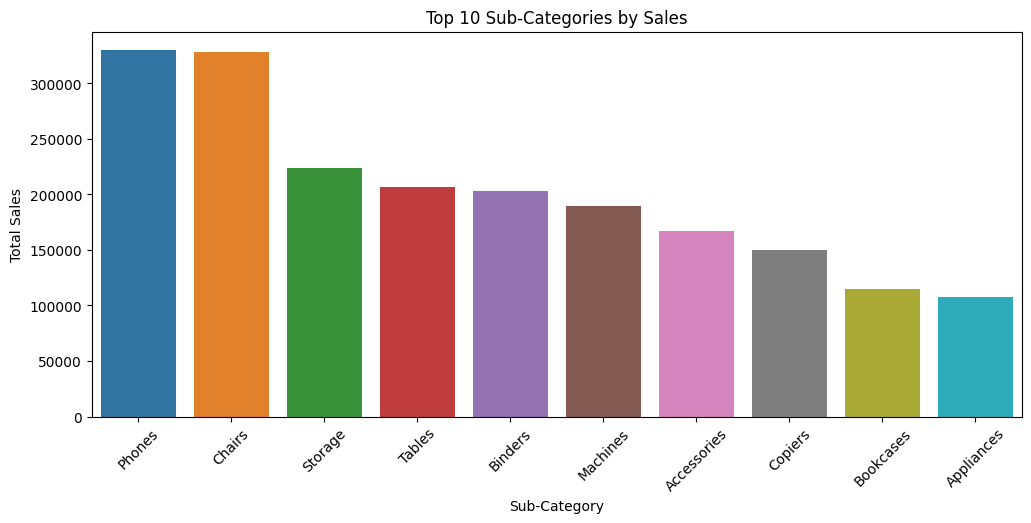

In [24]:
top_sub = duckdb.sql("""
    SELECT "Sub-Category", SUM("Sales") AS total_sales
    FROM superstore
    GROUP BY "Sub-Category"
    ORDER BY total_sales DESC
    LIMIT 10
""").df()

plt.figure(figsize=(12,5))
sns.barplot(data=top_sub, x="Sub-Category", y="total_sales")
plt.title("Top 10 Sub-Categories by Sales")
plt.xticks(rotation=45)
plt.ylabel("Total Sales")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">7. Regional Performance Analysis</h2>
</div>



Understanding which geographic regions perform best can reveal market opportunity
and highlight operational problems.

The query below shows:
- Total sales  
- Total profit  
- Average profit per order  

---



In [25]:
duckdb.sql("""
    SELECT 
        "Region",
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit,
        ROUND(AVG("Profit"), 2) AS avg_profit_per_order
    FROM superstore
    GROUP BY "Region"
    ORDER BY total_profit DESC
""")


┌─────────┬─────────────┬──────────────┬──────────────────────┐
│ Region  │ total_sales │ total_profit │ avg_profit_per_order │
│ varchar │   double    │    double    │        double        │
├─────────┼─────────────┼──────────────┼──────────────────────┤
│ West    │   725255.64 │    108329.81 │                33.93 │
│ East    │    678435.2 │     91506.31 │                32.16 │
│ South   │   391721.91 │     46749.43 │                28.86 │
│ Central │   500782.85 │     39655.88 │                 17.1 │
└─────────┴─────────────┴──────────────┴──────────────────────┘

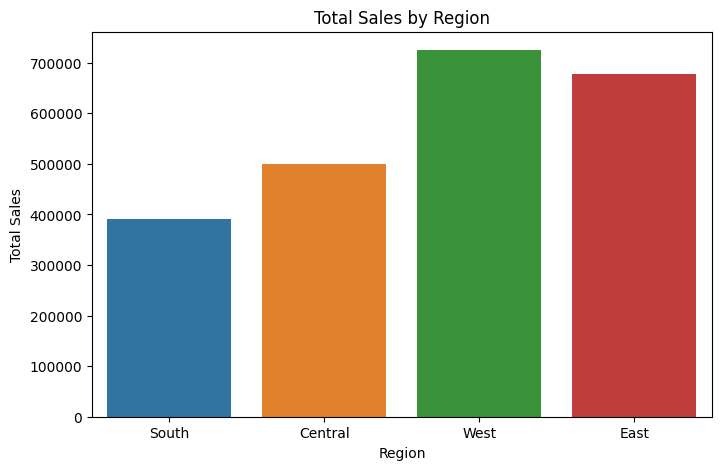

In [26]:
region_sales = duckdb.sql("""
    SELECT "Region", SUM("Sales") AS total_sales
    FROM superstore
    GROUP BY "Region"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=region_sales, x="Region", y="total_sales")
plt.title("Total Sales by Region")
plt.xlabel("Region")
plt.ylabel("Total Sales")
plt.show()


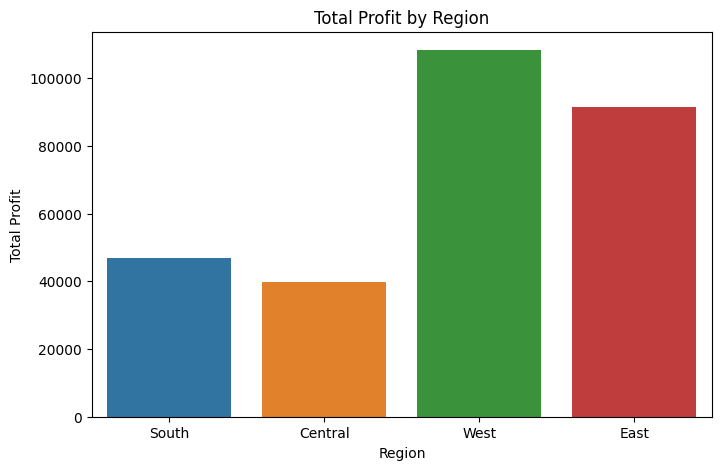

In [27]:
region_profit = duckdb.sql("""
    SELECT "Region", SUM("Profit") AS total_profit
    FROM superstore
    GROUP BY "Region"
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=region_profit, x="Region", y="total_profit")
plt.title("Total Profit by Region")
plt.xlabel("Region")
plt.ylabel("Total Profit")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">8. State-Level Profitability</h2>
</div>



Here we drill deeper into state-level performance to identify:
- Top 10 most profitable states  
- Bottom 10 least profitable states  

Low-profit states may indicate pricing issues, logistic costs, or competitive pressure.

---



In [28]:
# Top 10 States by total profit
duckdb.sql("""
    SELECT 
        "State",
        ROUND(SUM("Profit"), 2) AS total_profit
    FROM superstore
    GROUP BY "State"
    ORDER BY total_profit DESC
    LIMIT 10
""")


┌────────────┬──────────────┐
│   State    │ total_profit │
│  varchar   │    double    │
├────────────┼──────────────┤
│ California │     76330.79 │
│ New York   │     74015.46 │
│ Washington │     33368.24 │
│ Michigan   │     24428.09 │
│ Virginia   │     18597.95 │
│ Indiana    │     18382.94 │
│ Georgia    │     16250.04 │
│ Kentucky   │      11199.7 │
│ Minnesota  │     10823.19 │
│ Delaware   │      9977.37 │
├────────────┴──────────────┤
│ 10 rows         2 columns │
└───────────────────────────┘

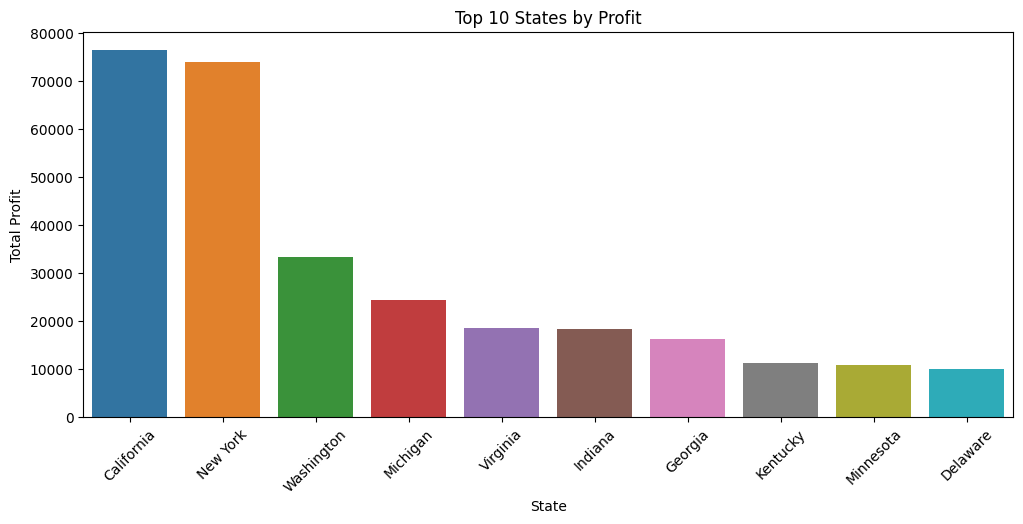

In [29]:
top_states = duckdb.sql("""
    SELECT "State", SUM("Profit") AS total_profit
    FROM superstore
    GROUP BY "State"
    ORDER BY total_profit DESC
    LIMIT 10
""").df()

plt.figure(figsize=(12,5))
sns.barplot(data=top_states, x="State", y="total_profit")
plt.title("Top 10 States by Profit")
plt.xticks(rotation=45)
plt.ylabel("Total Profit")
plt.show()


In [30]:
# Bottom 10 States by total profit (potential problem areas)
duckdb.sql("""
    SELECT 
        "State",
        ROUND(SUM("Profit"), 2) AS total_profit
    FROM superstore
    GROUP BY "State"
    ORDER BY total_profit ASC
    LIMIT 10
""")


┌────────────────┬──────────────┐
│     State      │ total_profit │
│    varchar     │    double    │
├────────────────┼──────────────┤
│ Texas          │    -25750.98 │
│ Ohio           │    -16959.32 │
│ Pennsylvania   │     -15565.4 │
│ Illinois       │    -12601.65 │
│ North Carolina │     -7490.91 │
│ Colorado       │     -6527.86 │
│ Tennessee      │     -5341.69 │
│ Arizona        │     -3427.92 │
│ Florida        │      -3399.3 │
│ Oregon         │      -1194.1 │
├────────────────┴──────────────┤
│ 10 rows             2 columns │
└───────────────────────────────┘

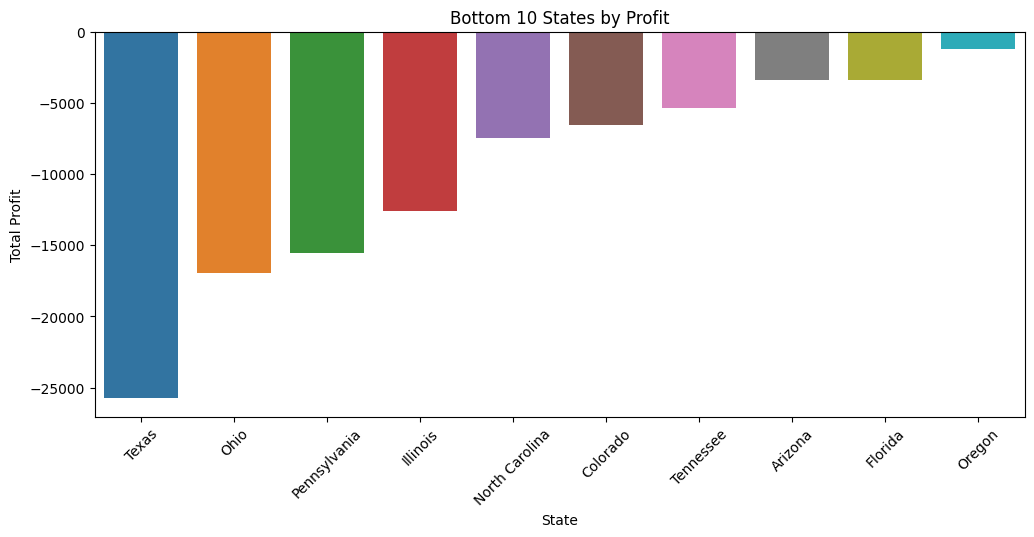

In [31]:
bottom_states = duckdb.sql("""
    SELECT "State", SUM("Profit") AS total_profit
    FROM superstore
    GROUP BY "State"
    ORDER BY total_profit ASC
    LIMIT 10
""").df()

plt.figure(figsize=(12,5))
sns.barplot(data=bottom_states, x="State", y="total_profit")
plt.title("Bottom 10 States by Profit")
plt.xticks(rotation=45)
plt.ylabel("Total Profit")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#2F3E34; padding:15px; border-radius:8px;">
  <h2 style="color:#F4F0EB; margin:0;">9. Shipping Mode Performance</h2>
</div>



Different shipping methods affect cost and profitability.
This section analyzes:

- Number of orders per ship mode  
- Total sales  
- Total profit  

This helps identify which modes contribute positively versus negatively.

---


In [32]:
duckdb.sql("""
    SELECT
        "Ship Mode",
        COUNT(*) AS num_orders,
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit,
        ROUND(AVG("Profit"), 2) AS avg_profit_per_order
    FROM superstore
    GROUP BY "Ship Mode"
    ORDER BY num_orders DESC
""")


┌────────────────┬────────────┬─────────────┬──────────────┬──────────────────────┐
│   Ship Mode    │ num_orders │ total_sales │ total_profit │ avg_profit_per_order │
│    varchar     │   int64    │   double    │    double    │        double        │
├────────────────┼────────────┼─────────────┼──────────────┼──────────────────────┤
│ Standard Class │       5955 │  1357316.35 │    163969.23 │                27.53 │
│ Second Class   │       1943 │   459177.05 │     57446.65 │                29.57 │
│ First Class    │       1537 │   351380.47 │     48953.66 │                31.85 │
│ Same Day       │        542 │   128321.72 │     15871.89 │                29.28 │
└────────────────┴────────────┴─────────────┴──────────────┴──────────────────────┘

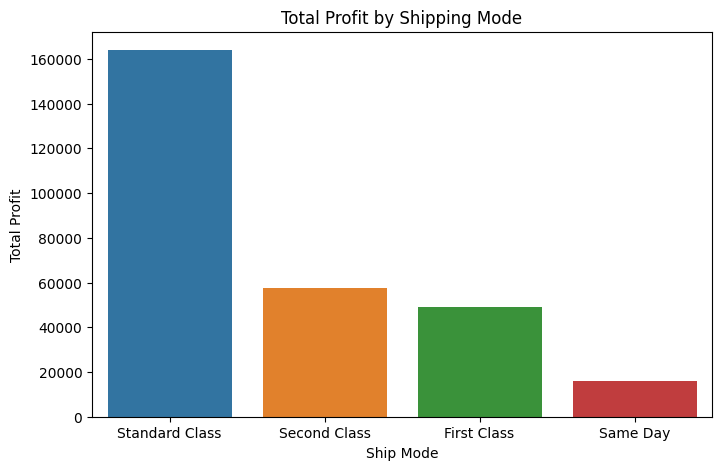

In [33]:
ship_mode_stats = duckdb.sql("""
    SELECT
        "Ship Mode",
        COUNT(*) AS num_orders,
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit
    FROM superstore
    GROUP BY "Ship Mode"
    ORDER BY num_orders DESC
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=ship_mode_stats, x="Ship Mode", y="total_profit")
plt.title("Total Profit by Shipping Mode")
plt.xlabel("Ship Mode")
plt.ylabel("Total Profit")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#B19CD9; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">10. Discount Impact on Profit</h2>
</div>



Discounting strategies dramatically affect profitability.
Using SQL, we evaluate how profit changes with varying discount levels.

<b>Insight Tip:</b>  
Steep discounts often produce negative profit margins.  
This analysis helps identify discount thresholds that harm financial health.


---


In [34]:
duckdb.sql("""
    SELECT
        "Discount",
        COUNT(*) AS num_rows,
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit,
        ROUND(AVG("Profit"), 2) AS avg_profit_per_row
    FROM superstore
    GROUP BY "Discount"
    ORDER BY "Discount"
""")


┌──────────┬──────────┬─────────────┬──────────────┬────────────────────┐
│ Discount │ num_rows │ total_sales │ total_profit │ avg_profit_per_row │
│  double  │  int64   │   double    │    double    │       double       │
├──────────┼──────────┼─────────────┼──────────────┼────────────────────┤
│      0.0 │     4787 │  1087277.56 │    320844.41 │              67.02 │
│      0.1 │       94 │    54369.35 │      9029.18 │              96.06 │
│     0.15 │       52 │    27558.52 │      1418.99 │              27.29 │
│      0.2 │     3653 │   764504.94 │     90306.61 │              24.72 │
│      0.3 │      226 │   102945.28 │    -10357.22 │             -45.83 │
│     0.32 │       27 │    14493.46 │     -2391.14 │             -88.56 │
│      0.4 │      206 │   116417.78 │    -23057.05 │            -111.93 │
│     0.45 │       11 │     5484.97 │     -2493.11 │            -226.65 │
│      0.5 │       66 │    58918.54 │    -20506.43 │             -310.7 │
│      0.6 │      138 │      6644.7 │ 

In [35]:
duckdb.sql("""
    SELECT
        CASE
            WHEN "Discount" = 0 THEN '0%'
            WHEN "Discount" > 0 AND "Discount" <= 0.10 THEN '0–10%'
            WHEN "Discount" > 0.10 AND "Discount" <= 0.30 THEN '10–30%'
            WHEN "Discount" > 0.30 AND "Discount" <= 0.50 THEN '30–50%'
            ELSE '>50%'
        END AS discount_bucket,
        COUNT(*) AS num_rows,
        ROUND(SUM("Sales"), 2) AS total_sales,
        ROUND(SUM("Profit"), 2) AS total_profit,
        ROUND(AVG("Profit"), 2) AS avg_profit_per_row
    FROM superstore
    GROUP BY discount_bucket
    ORDER BY discount_bucket
""")


┌─────────────────┬──────────┬─────────────┬──────────────┬────────────────────┐
│ discount_bucket │ num_rows │ total_sales │ total_profit │ avg_profit_per_row │
│     varchar     │  int64   │   double    │    double    │       double       │
├─────────────────┼──────────┼─────────────┼──────────────┼────────────────────┤
│ 0%              │     4787 │  1087277.56 │    320844.41 │              67.02 │
│ 0–10%           │       94 │    54369.35 │      9029.18 │              96.06 │
│ 10–30%          │     3931 │   895008.75 │     81368.38 │               20.7 │
│ 30–50%          │      310 │   195314.76 │    -48447.73 │            -156.28 │
│ >50%            │      855 │    64225.17 │    -76552.81 │             -89.54 │
└─────────────────┴──────────┴─────────────┴──────────────┴────────────────────┘

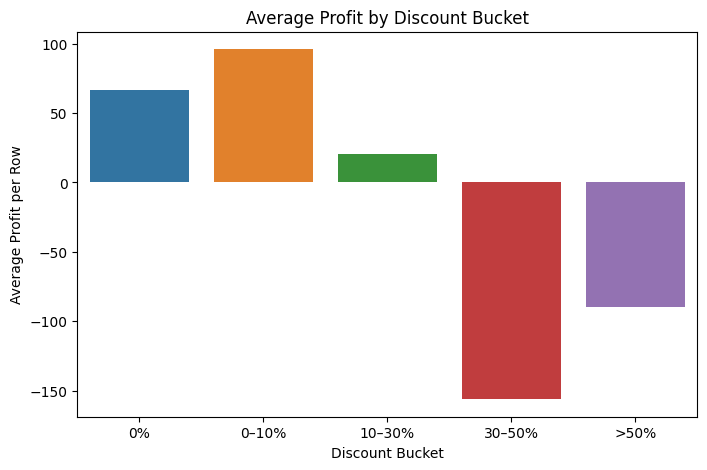

In [36]:
discount_bucket_stats = duckdb.sql("""
    SELECT
        CASE
            WHEN "Discount" = 0 THEN '0%'
            WHEN "Discount" > 0 AND "Discount" <= 0.10 THEN '0–10%'
            WHEN "Discount" > 0.10 AND "Discount" <= 0.30 THEN '10–30%'
            WHEN "Discount" > 0.30 AND "Discount" <= 0.50 THEN '30–50%'
            ELSE '>50%'
        END AS discount_bucket,
        ROUND(AVG("Profit"), 2) AS avg_profit_per_row
    FROM superstore
    GROUP BY discount_bucket
    ORDER BY discount_bucket
""").df()

plt.figure(figsize=(8,5))
sns.barplot(data=discount_bucket_stats, x="discount_bucket", y="avg_profit_per_row")
plt.title("Average Profit by Discount Bucket")
plt.xlabel("Discount Bucket")
plt.ylabel("Average Profit per Row")
plt.show()


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#2F3E34; padding:15px; border-radius:8px;">
  <h2 style="color:#F4F0EB; margin:0;">11. Strategic Recommendations</h2>
</div>



Based on the patterns, trends, and performance signals uncovered in the Superstore dataset, the following strategic recommendations outline actionable steps the business can take to improve profitability, strengthen operations, and support long-term growth. These solutions reflect a blend of big-picture insight and systems-level thinking, connecting individual data points to broader business dynamics.

1. **Reevaluate Unprofitable Furniture Sub-Categories** 

Furniture generates strong revenue but often produces negative profit, especially in Tables and Bookcases.
Recommendations:

Conduct a cost analysis (shipping fees, supplier pricing, weight, handling).

Reduce or redesign SKUs that consistently lose money.

Promote profitable alternatives like Chairs or Storage.

Explore supplier renegotiations or lighter product formats.

Expected Impact:
Strengthens margins and reduces losses without sacrificing revenue.


2. **Implement Smarter Discounting Practices**

Deep discounts are closely linked to profit erosion across multiple categories.
Recommendations:

Set maximum discount limits for low-margin products.

Use tiered discounting based on inventory levels and margin history.

Shift from item-level discounts to bundled promotions.

Review discount effectiveness monthly.

Expected Impact:
Protects profitability while maintaining promotional flexibility.


3. **Address Loss-Making Geographic Regions**

States like Texas, Ohio, Pennsylvania, and Illinois consistently show negative profit.
Recommendations:

Identify region-specific cost drivers (shipping, returns, demand patterns).

Adjust regional pricing strategies.

Optimize shipping routes or local warehousing.

Reallocate marketing spend to stronger regions.

Expected Impact:
Reduces systematic financial leakage and improves regional performance.


4. **Optimize Shipping Mode Efficiency**

Shipping mode plays a major role in cost-to-serve and overall profitability.
Recommendations:

Identify which shipping modes contribute negative profit.

Offer incentives for cost-efficient shipping choices at checkout.

Negotiate updated shipping rates with carriers.

Limit expensive shipping options for low-margin categories.

Expected Impact:
Improves logistics profitability and lowers operational cost.


5. **Amplify High-Performing Regions**

The West and East regions consistently outperform other areas in total profit and average order profitability.
Recommendations:

Increase inventory availability for top sellers in strong regions.

Prioritize marketing campaigns in high-yield areas.

Pilot new products regionally before scaling nationwide.

Expected Impact:
Accelerates solid performance and compounds profitable growth.


6. **Expand Technology & Office Supply Offerings**

Technology is the largest revenue driver and highly profitable.
Office Supplies provide stability and recurring purchases.
Recommendations:

Introduce product extensions in trending tech categories.

Create replenishment subscriptions for office supplies.

Bundle high-margin tech products with mid-margin accessories.

Expected Impact:
Increases revenue consistency and boosts long-term profitability.


7. **Conduct Root-Cause Analysis on Low-Margin Items**

Categories with chronic negative profit require deeper investigation.
Recommendations:

Analyze product lifecycle (shipping cost, demand patterns, discount frequency).

Test alternative fulfillment strategies (flat-pack furniture, slower shipping).

Consider retiring chronically negative product lines.

Expected Impact:
Protects the business from silent, ongoing losses.


8. **Establish Region-Specific Pricing Models**

Demand and cost structure differ across states and regions.
Recommendations:

Use dynamic, region-adjusted pricing to match local cost-to-serve.

Expand free shipping only in profitable regions.

Increase prices slightly in areas with high demand and high profitability.

Expected Impact:
Better alignment between pricing, demand, and operational efficiency.


9. **Enhance Future Data Collection**

The ability to produce deeper insights is limited by missing fields such as customer ID, order ID, order date, and ship date.
Recommendations:

Improve data capture across all customer and order touchpoints.

Enable advanced customer segmentation, churn analysis, and LTV modeling.

Track time-based trends to improve forecasting and inventory planning.


Expected Impact:
Transforms the business from reactive to predictive strategy.

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

 
<div style="background-color:#B19CD9; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">12. Summary Insights</h2>
</div>




## Profitability by Region – Visual Summary


In [37]:
print("""
West        ████████████████████  High profit

East        ██████████████████    Strong profit

South       ███████████           Moderate profit

Central     █████████             Lower profit
""")


West        ████████████████████  High profit

East        ██████████████████    Strong profit

South       ███████████           Moderate profit

Central     █████████             Lower profit



Insight:
The West and East dominate profitability. Central and South struggle comparatively.

## Profitability by Category – Visual Summary

In [38]:
print("""
Technology        ███████████████████████  Profit leader
Office Supplies   ███████████████          Steady, reliable
Furniture         ███                      Weak profit despite high sales
""")




Technology        ███████████████████████  Profit leader
Office Supplies   ███████████████          Steady, reliable
Furniture         ███                      Weak profit despite high sales



Insight:
Technology is the engine of the business. Furniture is a revenue trap.

## Discount Level Impact – Visual Summary

In [39]:
print("""
0% Discount          █████████████████    Healthy profit
0–10% Discount       ███████████          Stable
10–30% Discount      ████                 Declining profit
30–50% Discount      ██                   Significant loss
>50% Discount        █                    Extreme loss
""")


0% Discount          █████████████████    Healthy profit
0–10% Discount       ███████████          Stable
10–30% Discount      ████                 Declining profit
30–50% Discount      ██                   Significant loss
>50% Discount        █                    Extreme loss



Insight:
The deeper the discount, the more profit collapses.

## Shipping Mode Performance – Visual Summary

In [40]:
print(""" 
Shipping Mode Performance – Visual Summary
Standard Class      █████████████  Most orders, moderate profit
Second Class        ████████       Balanced performance
First Class         ███████        High cost, mixed margin
Same Day            ██             High cost, lowest volume
""")

 
Shipping Mode Performance – Visual Summary
Standard Class      █████████████  Most orders, moderate profit
Second Class        ████████       Balanced performance
First Class         ███████        High cost, mixed margin
Same Day            ██             High cost, lowest volume



Insight:
Shipping cost strategy is deeply tied to product profitability.

## State-Level Profitability Patterns

In [41]:
print("""
Top States:
California     ███████████████████████
New York       █████████████████████
Washington     ██████████████

Bottom States:
Texas          ███
Ohio           ██
Pennsylvania   ██
Illinois       ██
Florida        ██
""")


Top States:
California     ███████████████████████
New York       █████████████████████
Washington     ██████████████

Bottom States:
Texas          ███
Ohio           ██
Pennsylvania   ██
Illinois       ██
Florida        ██



Insight:
Certain states systematically bleed profit and require deeper root-cause analysis.

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">13. Organizational Development & Change Lens</h2>
</div>

___


The recommendations provided in this analysis are framed not only through a data lens but also through organizational development and change and systems-thinking principles. Improving an organization’s performance requires understanding the interconnected systems that influence sales, logistics, customer behavior, supply chain, pricing strategy, internal processes, and market conditions.

These suggestions should be viewed as being representative of strategic starting points based on the available dataset. However, they should be viewed as exploratory starting points rather than prescriptive solutions. Because the dataset does not include historical performance trends, customer ids, repeat purchase behavior, order dates, shipping timelines, seasonal patterns, or operational metrics, it is not possible to state with full certainty which solutions should be implemented.

Instead, these insights serve as food for thought. Basically, indicators of where deeper investigation, cross-departmental collaboration, and organizational learning may be necessary. A complete change-management plan would require:

* Historical data to understand long-term performance stability

* Customer-level data for segmentation and lifetime value modeling

* Operational metrics (ship times, costs, returns) to diagnose failures

* Market data to understand competition and pricing context

That said, it is not possible to determine with full certainty which organizational changes should be implemented. These insights serve as thoughtful, data-supported signals that can guide deeper investigation, controlled pilot testing, and cross-functional review before making any major organizational decisions. Any recommended changes should be approached through a pilot-first mindset, testing interventions in controlled environments before rolling out phased large-scale organizational changes.

This ensures the company avoids unintended consequences and builds sustainable, evidence-backed improvements over time.

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">

<div style="background-color:#B19CD9; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">14. Summary Insights</h2>
</div>

<div style="background-color:#000000; padding:18px; border-radius:12px; border:1px solid #A3B9A5; margin-top:10px;">
  <h3 style="color:#1C1C1E; margin-top:0;">✔ Key Findings</h3>
  <ul>
    <li>Technology is the strongest revenue driver with solid profitability.</li>
    <li>Furniture generates strong sales but weak profit, especially in Tables.</li>
    <li>State-level performance shows major losses in Texas, Ohio, and Pennsylvania.</li>
    <li>Discounting correlates strongly with profit erosion at higher levels.</li>
    <li>Shipping mode distributions provide opportunities for logistical optimization.</li>
  </ul>
</div>

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">


<div style="background-color:#2F3E34; padding:15px; border-radius:8px;">
  <h2 style="color:#F4F0EB; margin:0;">15. Dataset Limitations</h2>
</div>



While the Superstore dataset provides valuable insight into product performance, regional profitability, and discount behavior, it also contains several important limitations that affect the depth and certainty of the analysis.

---

### **Missing Customer & Order Identifiers**

This version of the dataset does not include:

- Customer Name  
- Customer ID  
- Order ID  
- Order Date  
- Ship Date  

Because of this, the following analyses are not possible:

- Customer segmentation  
- Order frequency or repeat purchase analysis  
- Customer lifetime value (LTV)  
- Cohort or churn analysis  
- Seasonality or forecasting based on historical trends  

---

### **Missing Sales Channel Information**

There is no indication of whether orders came from online purchases or physical retail stores.  
The dataset lacks:

- Online Order vs. In-Store flag  
- Store Purchase indicator  
- Channel field  
- Store ID or branch location  
- Sales associate or point-of-sale metadata  

Although every transaction includes a shipping method — which **suggests** e-commerce behavior — the dataset does *not* explicitly confirm whether these orders represent online-only activity.  
Without channel data, it is impossible to evaluate:

- Online vs. in-store performance  
- Channel-specific profitability  
- Whether low-performing states reflect online logistics inefficiencies  
- How brick-and-mortar strategy affects sales and profit  

---

### **Missing Operational & Retail Context**

The dataset does not provide:

- Delivery vs. pickup information  
- Store locations or regional retail distribution  
- SKU placement, inventory allocation, or in-store merchandising  
- Return rates or return reasons  

Because of this, we cannot determine:

- Whether certain states rely more heavily on online fulfillment  
- Whether bulky or low-margin items are disproportionately bought online  
- Whether negative profit in some states is caused by shipping, freight, or return behavior  
- How operational factors influence profitability across regions  

---

### **Conclusion on Limitations**

Recognizing these gaps is critical because they influence how confidently we can interpret state-level profitability and product performance.  
While category, region, discount, and shipping analyses remain valid, the absence of customer identifiers, store information, and channel context limits deeper insights into customer behavior, operational efficiency, and long-term strategic forecasting.


<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">



<div style="background-color:#A3B9A5; padding:15px; border-radius:8px;">
  <h2 style="color:#1C1C1E; margin:0;">16. Future Work</h2>
</div>



To expand this project, future datasets could enable:
- Customer lifetime value modeling  
- Churn prediction  
- Time-series forecasting  
- Market basket analysis  
- Price elasticity modeling  

<hr style="border:0; height:2px; background-color:#B19CD9; margin:30px 0;">


<div style="background-color:#1C1C1E; color:#F4F0EB; padding:18px; border-radius:10px; margin-top:40px; font-size:0.9rem;">
  <strong>Notebook Author:</strong> Lynn Clemons<br>
  Aspiring Business Intelligence & Strategy Analyst<br>
  Focus: Data storytelling, systems thinking, and decision support.<br><br>

  <strong>Tools Used:</strong><br>
  DuckDB · SQL · Python · Pandas · Matplotlib · Seaborn · Excel<br><br>

  <strong>Brand Palette:</strong><br>
  Deep Moss Green (#2F3E34) · Charcoal (#1C1C1E) · Lavender (#B19CD9)<br>
  Soft Cream (#F4F0EB) · Muted Sage (#A3B9A5)

  <hr style="border:0; border-top:1px solid #A3B9A5; margin-top:12px;">

  <div style="font-size:0.8rem; text-align:center;">
    This notebook is part of my BI strategy portfolio, demonstrating how I connect data, systems thinking, and organizational insight to support better business decisions.

  </div>
</div>


 This notebook is one step in my path toward Business Intelligence and Strategy work. I’m still learning SQL and Python, and I lean on AI as a support tool, but my strength is connecting data to the bigger picture: how systems behave, where value is leaking, and where thoughtful changes can make a real difference.

